### Exploration of Evaluation

In [1]:
import torch
import os

import numpy as np
import pandas as pd

from collections import OrderedDict

from src.data.dataloader import get_loaders
from src.models.model import get_model, PredictiveEncoder
from src.evaluation.figures import plot_marginal_frequency
from src.evaluation.pruning import prune_encoder_, pruning_status
from src.models.test import predict, run_inference

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from codecarbon import EmissionsTracker
from memory_profiler import memory_usage

In [2]:
# plot style
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

In [3]:
experiment_name = 'final-model'

device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load stored checkpoint
checkpoint = torch.load(f'../../models/{experiment_name}/best.ckpt')
encoder_state_dict = OrderedDict({layer_: weights_ for (layer_, weights_) in checkpoint['state_dict'].items() if 'decoder' not in layer_})

# Load pre-trained model
model, _, _, _ = get_model(model_name=checkpoint['model']['name'], device=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print("Model loaded !")
print(f"Device: {device}")

print(f"\nEncoder parameters: \t\t{sum(param_.numel() for param_ in model.encoder.parameters()) + sum(param_.numel() for param_ in model.encoder_fc.parameters()) + sum(param_.numel() for param_ in model.latent_classifier.parameters())}")
print(f"Decoder parameters: \t\t{sum(param_.numel() for param_ in model.decoder.parameters()) + sum(param_.numel() for param_ in model.decoder_fc.parameters())}")
print(f"Total number of parameters: \t{sum(param_.numel() for param_ in model.parameters())}")

Model loaded !
Device: cuda

Encoder parameters: 		403301
Decoder parameters: 		187075
Total number of parameters: 	590376


In [4]:
encoder = PredictiveEncoder().to(device)
encoder.load_state_dict(encoder_state_dict)
encoder.eval()

print("Model loaded !")
print(f"Encoder parameters: {sum(param_.numel() for param_ in encoder.parameters())}")

Model loaded !
Encoder parameters: 403301


In [5]:
# Load data
loaders, mu, sigma = get_loaders(
    data_path = '../../data',
    balancing_strategy='downsample',
    batch_size=checkpoint['training_parameters']['batch_size'],
    shuffle=True,
    val_size=0.2,
    seed=checkpoint['seed'],
)

In [6]:
latent_representations_train, pred_train, prob_train, ttrain, eq_train  = run_inference(loaders['train'], encoder, device=device)
latent_representations_val, pred_val, prob_val, tval, eq_val            = run_inference(loaders['val'], encoder, device=device)
latent_representations_test, pred_test, prob_test, _, _                 = run_inference(loaders['test'], encoder, device=device)

100%|██████████| 84/84 [00:01<00:00, 73.68it/s]


In [7]:
from sklearn.metrics import recall_score, roc_auc_score

In [8]:
print(f"\nTrain accuracy: {eq_train.mean()}")
print(f"Validation accuracy: {eq_val.mean()}")

print(f"\nTrain balanced accuracy: {balanced_accuracy_score(ttrain, pred_train)}")
print(f"Validation balanced accuracy: {balanced_accuracy_score(tval, pred_val)}")

print(f"\nTrain recall: {recall_score(ttrain, pred_train, average='weighted')}")
print(f"Validation recall: {recall_score(tval, pred_val, average='weighted')}")

print(f"\nTrain auc: {roc_auc_score(ttrain, prob_train, multi_class='ovr')}") # one-vs-rest
print(f"Validation auc: {roc_auc_score(tval, prob_val, multi_class='ovr')}") # one-vs-rest


Train accuracy: 0.9405633802816902
Validation accuracy: 0.8448667044809983

Train balanced accuracy: 0.9405633802816901
Validation balanced accuracy: 0.8108847357158615

Train recall: 0.9405633802816902
Validation recall: 0.8448667044809983

Train auc: 0.9968497569926601
Validation auc: 0.96670649158554


#### Utility functions - decision theory

***Note:*** I have used normalization by row (the true class) as the confusion matrix then presents the recall score. This means that it tells us something about how many of the actually positive samples our model predict, i.e. we see if the model is not capable of capturing the actual class. This is important as we do not want to make errors on certain classes - e.g. the alarm.

In [9]:
results = {
    'train': {
        'labels': ttrain,
        'preds': pred_train,
        'probs': prob_train,
        'z': latent_representations_train,
    },
    'validation': {
        'labels': tval,
        'preds': pred_val,
        'probs': prob_val,
        'z': latent_representations_val,
    },
    'test': {
        'labels': None,
        'preds': pred_test,
        'probs': prob_test,
        'z': latent_representations_test,
    }
}

U = np.identity(5)

model_name = checkpoint['model']['name']

In [10]:
from figures import visualize_utility, visualize_confusion_matrix

def compute_calibration_curve(targets, probs, num_bins=10):

    bins = np.linspace(0, 1, num_bins+1)

    p_true_mean, p_true_se, p_pred = [], [], []

    for i in range(num_bins):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_center = 0.5*(bin_start + bin_end)
        
        bin_idx = np.logical_and(bin_start <= probs, probs < bin_end)
        num_points_in_bin = np.sum(bin_idx)
        
        if len(targets[bin_idx]) == 0:
            continue

        p_pred.append(bin_center)
        p_est = np.mean(targets[bin_idx])
        p_true_mean.append(p_est)
        p_true_se.append(np.sqrt(p_est*(1-p_est)/num_points_in_bin))
        
    return np.array(p_true_mean), np.array(p_true_se), np.array(p_pred)
    
def visualize_results(results, U, model_name):
     
    # computing the expected utility for each class
    EU_train = prob_train @ U
    EU_val = prob_val @ U

    # not one hot
    U_ttrain = EU_train.argmax(axis=1)
    U_tval = EU_val.argmax(axis=1)

    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

    combinations = [
        (results['train']['labels'], U_ttrain, 'Train - Precision'), 
        (results['train']['labels'], U_ttrain, 'Train - Recall'),
        (results['validation']['labels'], U_tval, 'Validation - Precision'),
        (results['validation']['labels'], U_tval, 'Validation - Recall'),
    ]

    for target_, pred_, title_ in combinations:
        # plot everything
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # utility matrix
        visualize_utility(axes[0], U, labels=idx2label.values())

        # plotting the new confusion matrix
        cm = confusion_matrix(target_, pred_, normalize=('true' if 'recall' in title_.lower() else 'pred'))
        fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm, model_name, title_)

        fig.subplots_adjust(wspace=0.4)
        plt.show()
    
    for dtype in ['train', 'validation', 'test']:
        fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(18, 4))
        for i in range(5):
            axs[i].hist(results[dtype]['probs'][:, i], density=True, color=colors[i], label=idx2label[i])
            axs[i].legend()

        plt.xlim(-0.1, 1.1)
        fig.suptitle(f'{dtype.upper()} - Probability score distribution per category')
        plt.show()

    for dtype in ['train', 'validation']:
        fig, axes = plt.subplots(1, 5, figsize=(28, 4))
        for class_idx in range(5):
            ax = axes.flatten()[class_idx]
            p_true_mean, p_true_se, p_pred = compute_calibration_curve(results[dtype]['labels']==class_idx, results[dtype]['probs'][:, class_idx])
            ax.errorbar(p_pred, p_true_mean, p_true_se, label=idx2label[class_idx], color=colors[class_idx], marker='o', markersize=8)
            ax.plot([0, 1], [0, 1], 'k-', alpha=0.4)
            ax.legend(loc='upper left')
    
            ax.set_xlabel('Predicted probability')
        axes[0].set_ylabel('True probability')

        fig.subplots_adjust(wspace=0.1)
        fig.suptitle(f'{dtype.upper()} - Calibration curves')
        plt.show()

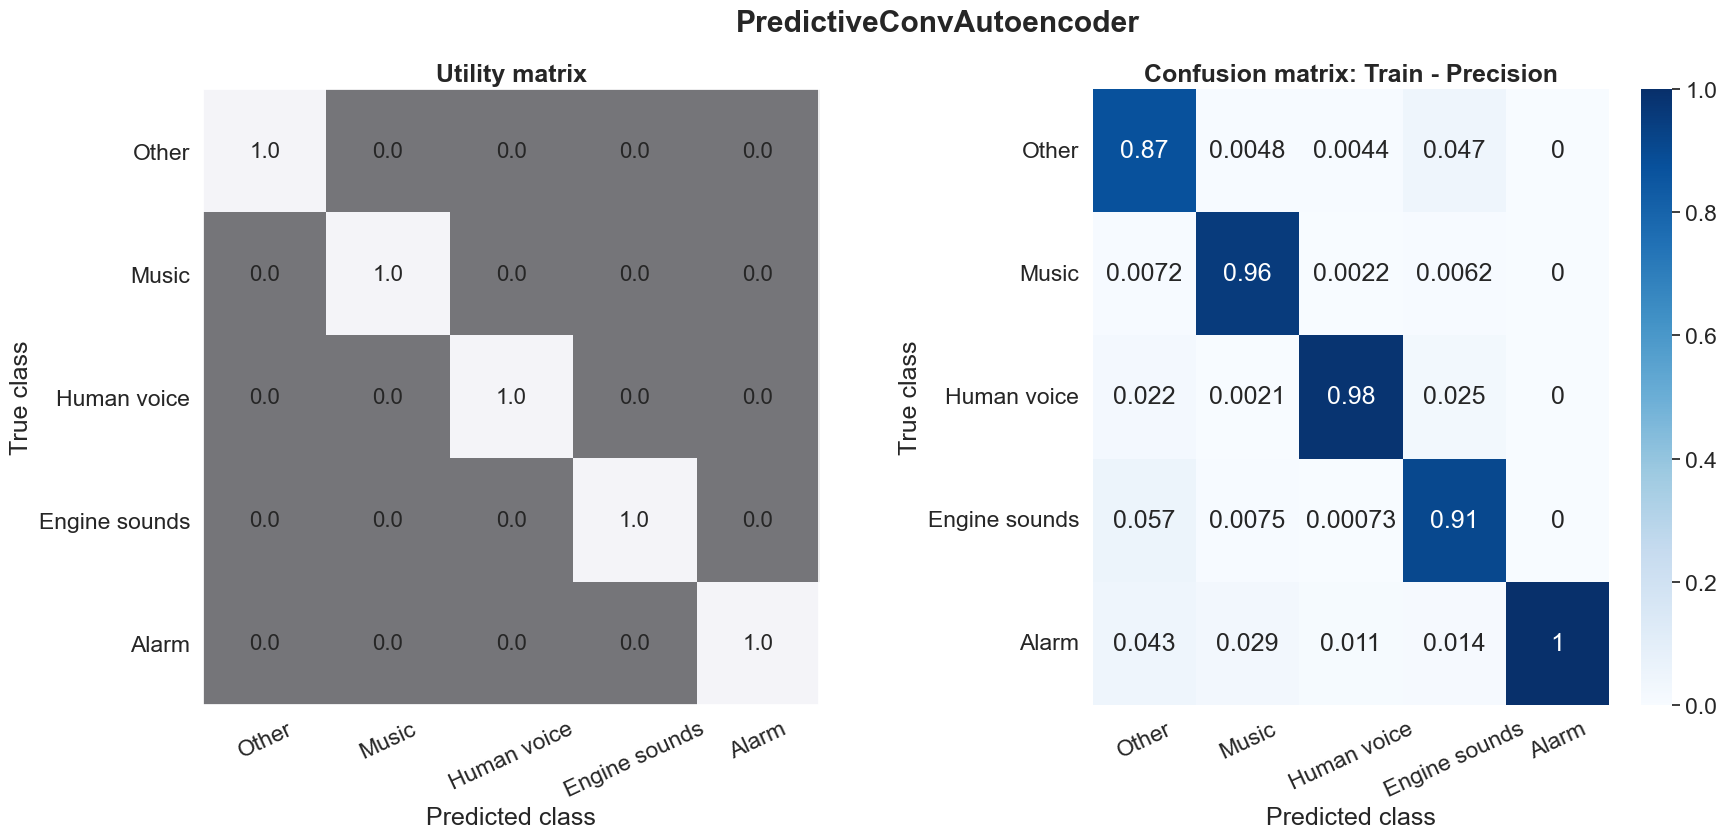

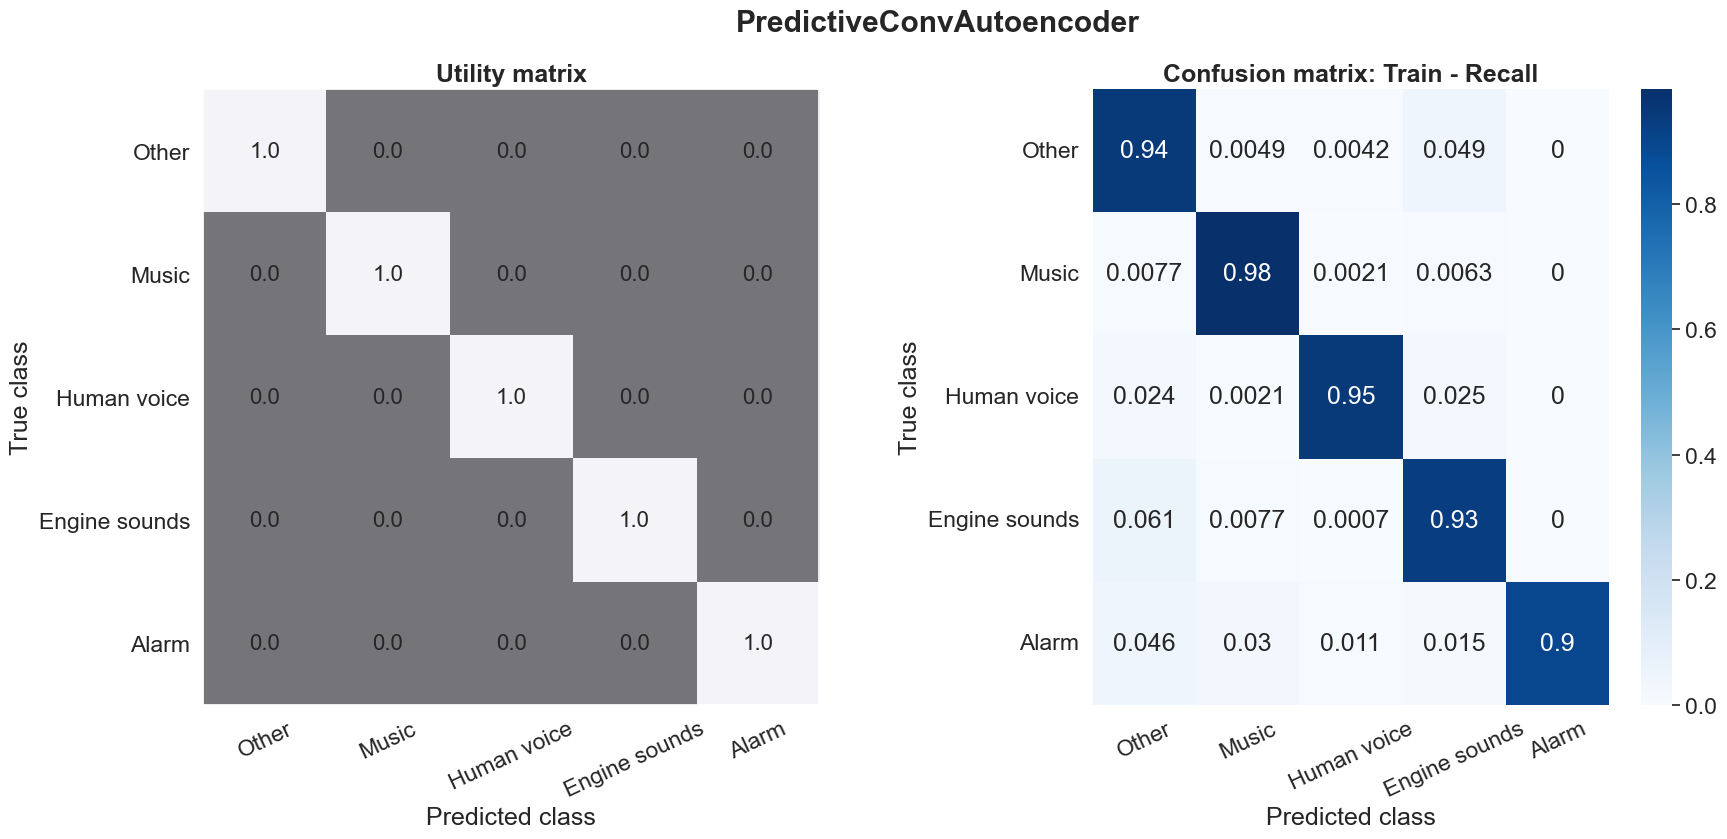

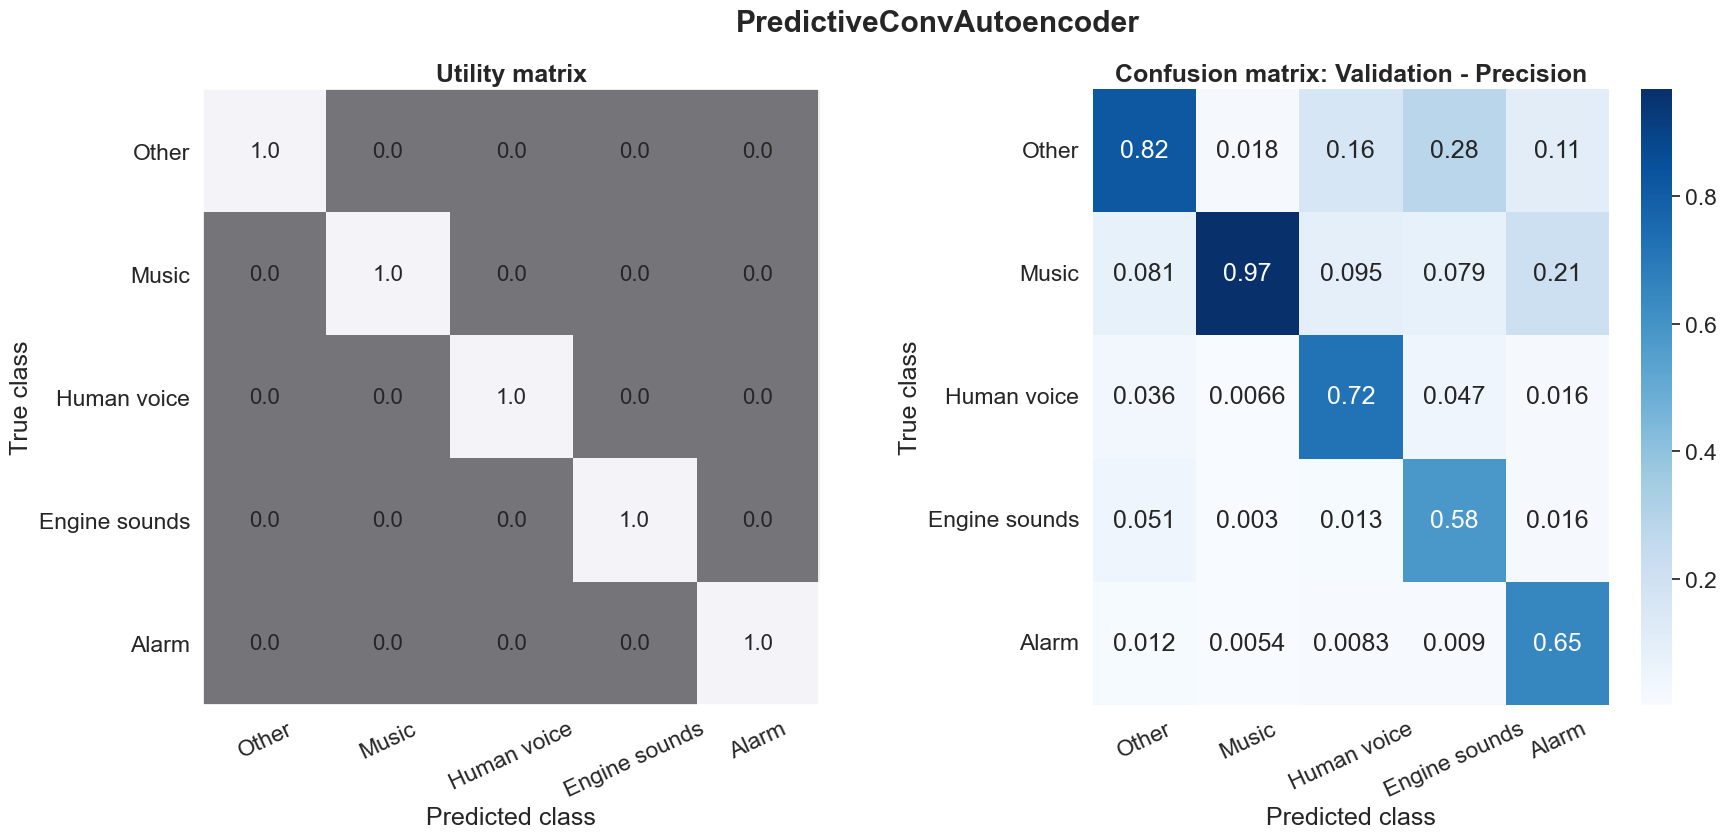

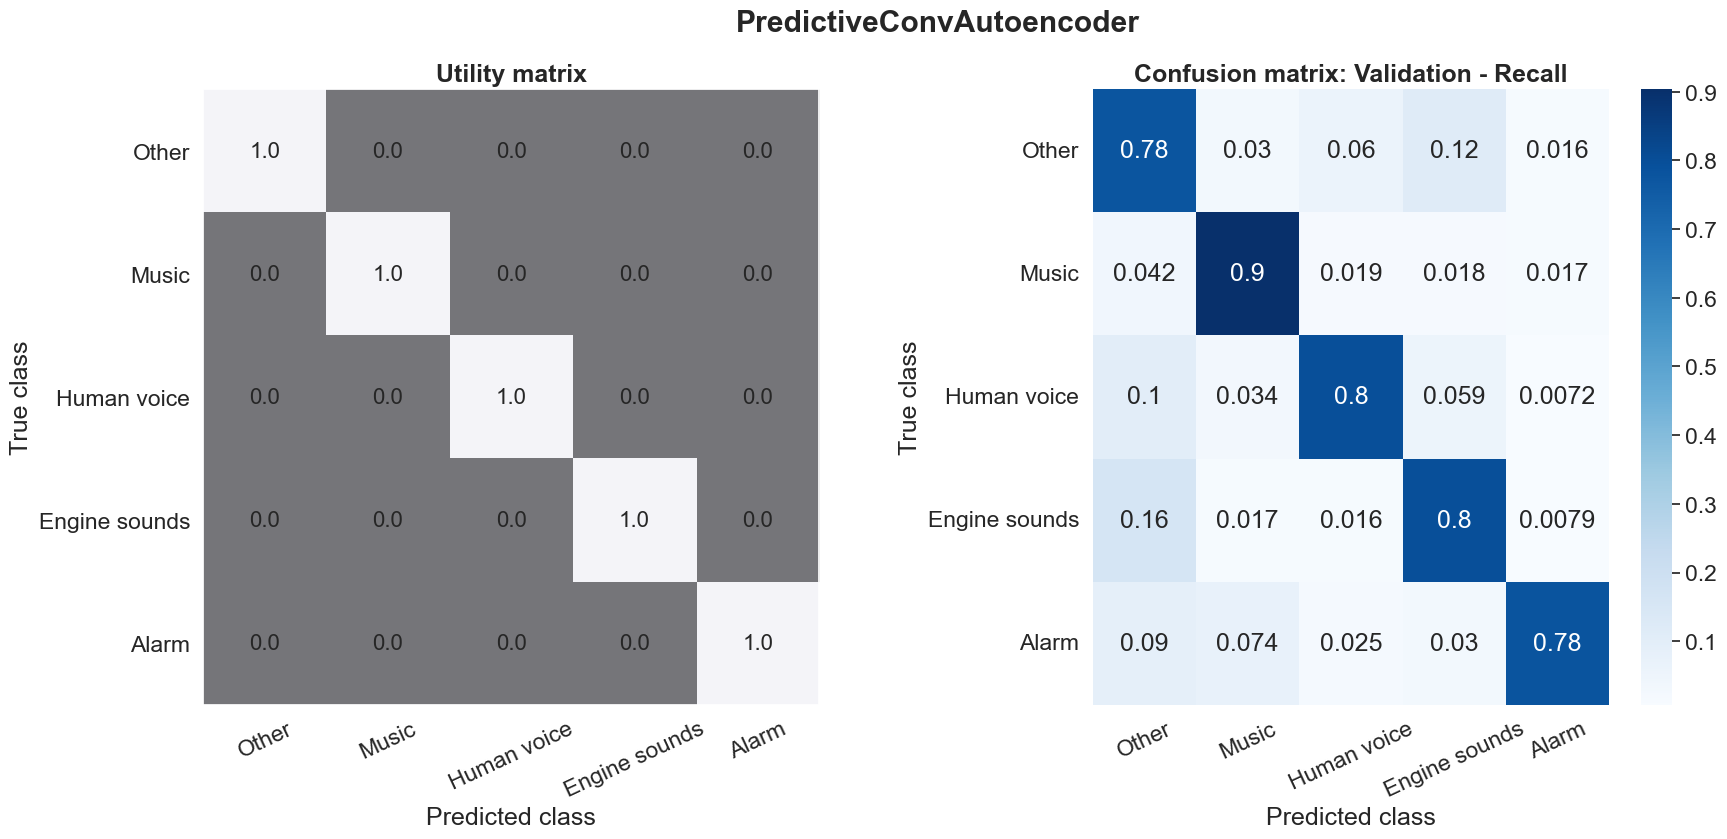

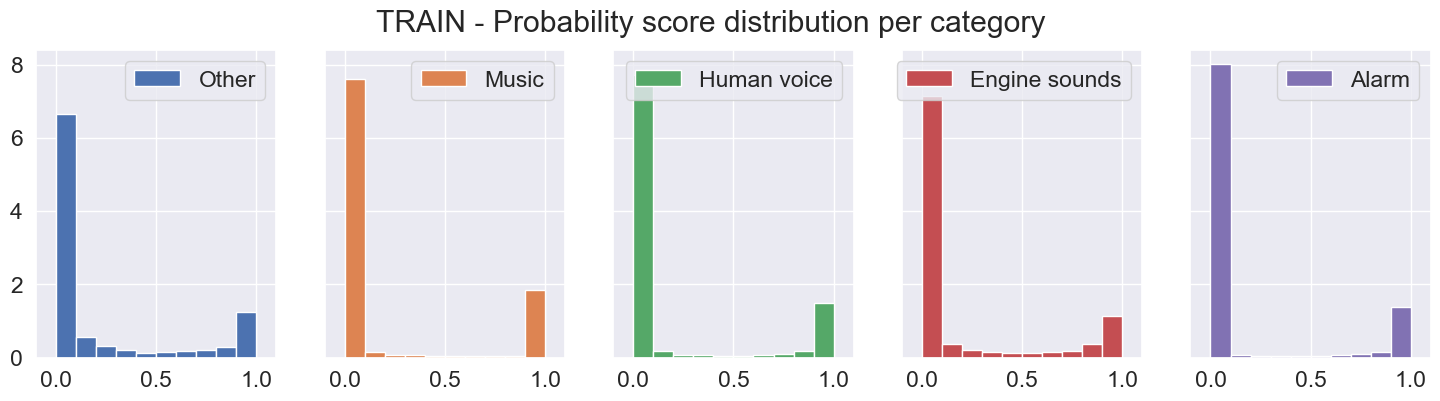

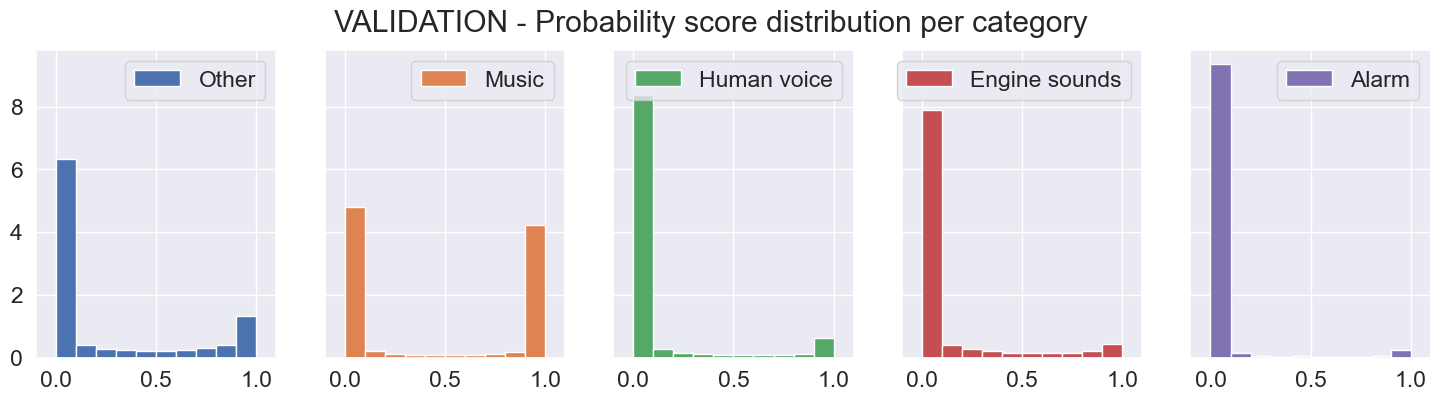

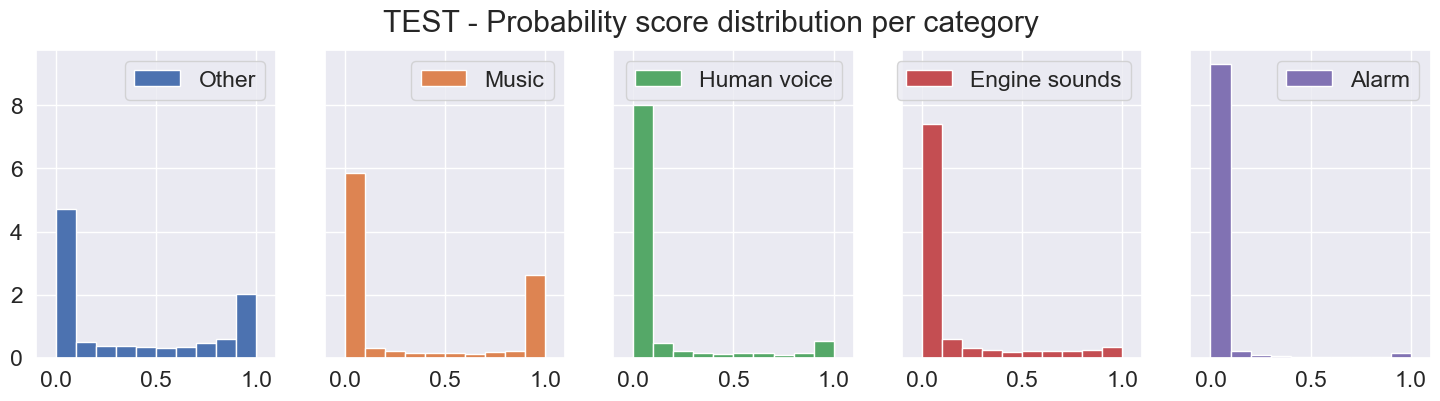

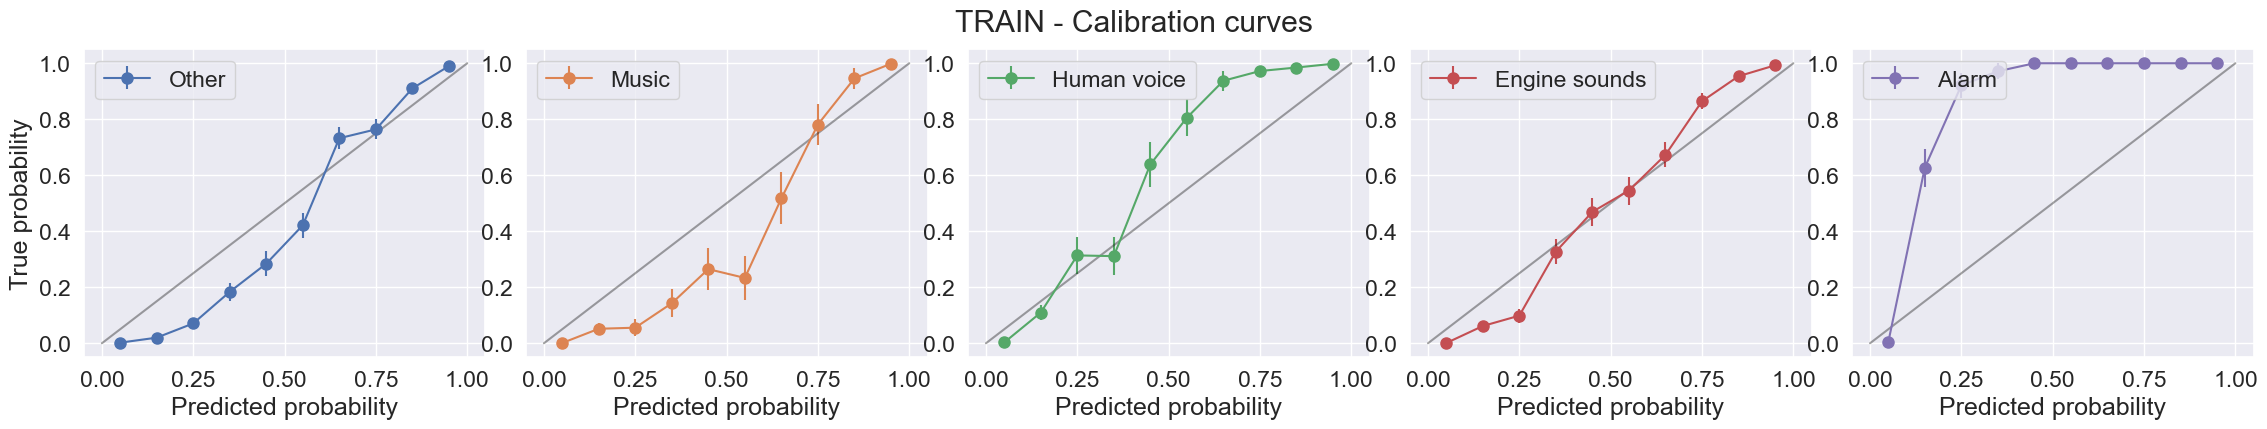

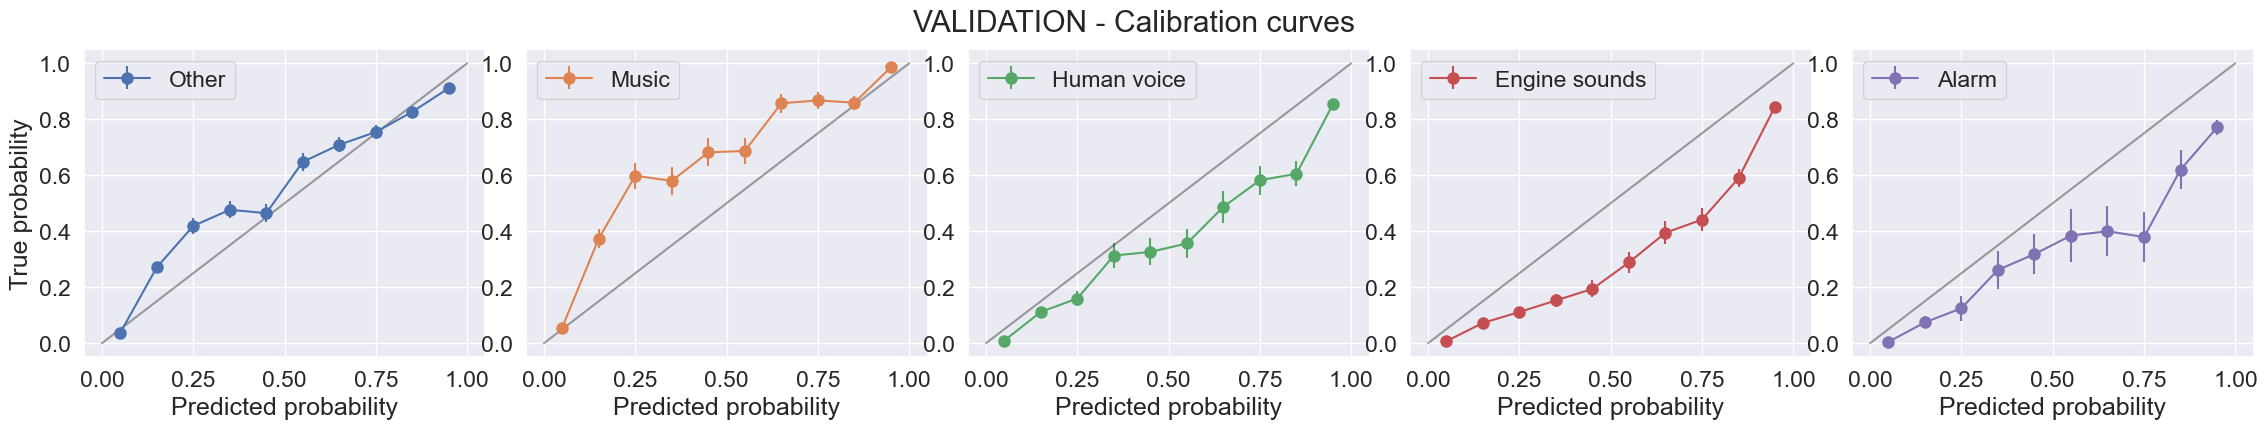

In [11]:
visualize_results(results, U, model_name)

### Analyzing the ressources used

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
# plot style
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

In [114]:
pruning_ = pd.DataFrame()
for i in range(1, 11):
    temp_ = pd.read_csv(f'../../pruning_results{i}.csv', index_col=0).T
    temp_[['duration', 'energy_consumed', 'memory_usage']] /= 64

    temp_['energy_consumed'] *= 1e6 # convert to milliwatt (mW)
    temp_['duration'] *= 1e3 # convert to milliseconds (ms)

    pruning_ = pd.concat([pruning_, temp_])
    

In [115]:
pruning = pruning_.groupby('pruning_ratio').mean().reset_index()
pruning_err = (pruning_.groupby('pruning_ratio').std() / np.sqrt(10)).reset_index()

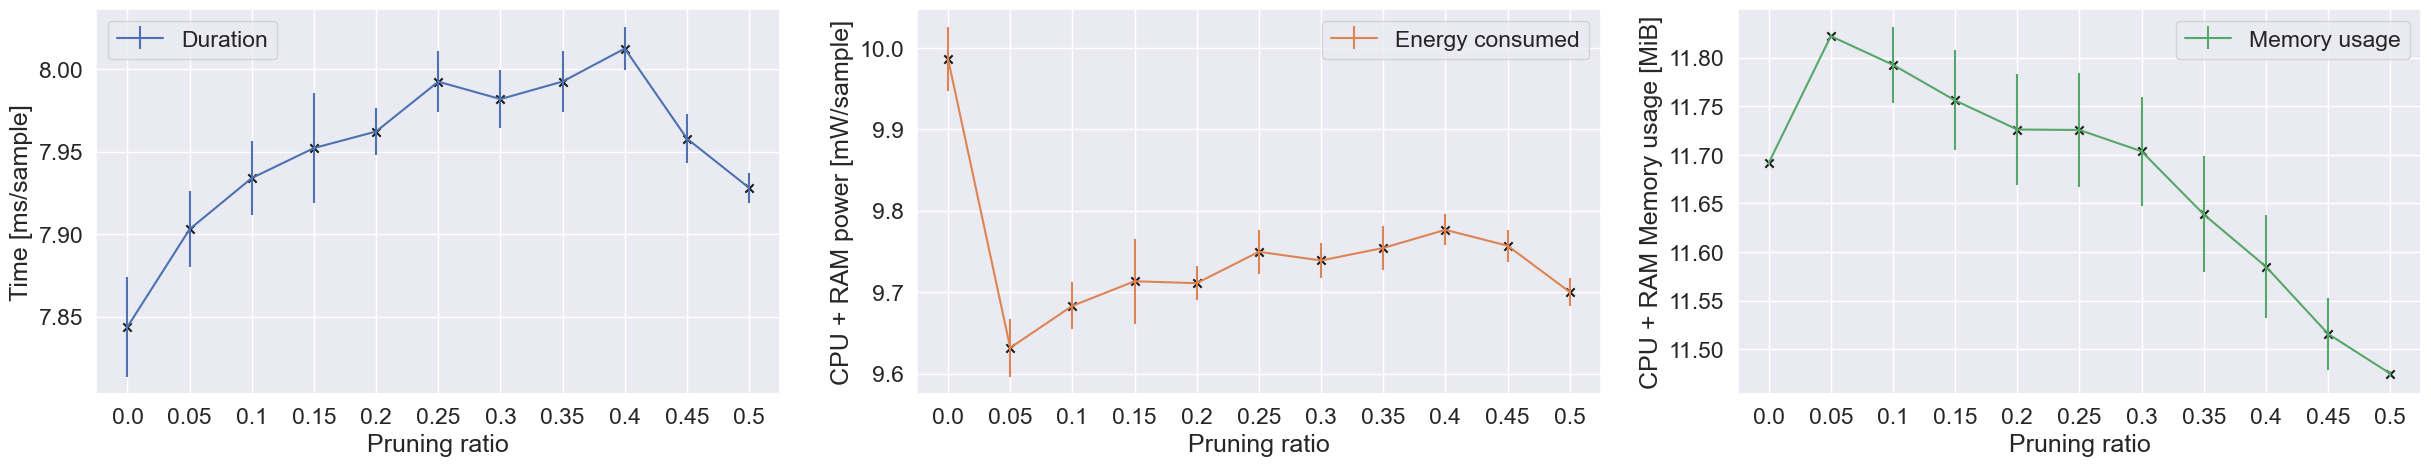

In [116]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(30, 5))

axs[0].errorbar(pruning['pruning_ratio'], pruning['duration'], yerr=pruning_err['duration'], color='C0', label='Duration')
axs[0].scatter(pruning['pruning_ratio'], pruning['duration'], color='k', marker='x')
axs[0].legend()

axs[1].errorbar(pruning['pruning_ratio'], pruning['energy_consumed'], yerr=pruning_err['energy_consumed'], color='C1', label='Energy consumed')
axs[1].scatter(pruning['pruning_ratio'], pruning['energy_consumed'], color='k', marker='x')
axs[1].legend()

axs[2].errorbar(pruning['pruning_ratio'], pruning['memory_usage'], yerr=pruning_err['memory_usage'], color='C2', label='Memory usage')
axs[2].scatter(pruning['pruning_ratio'], pruning['memory_usage'], color='k', marker='x')
axs[2].legend()

axs[0].set_xticks(np.linspace(0, 0.5, 11), np.round(np.linspace(0, 0.5, 11), 3))


axs[0].set_xlabel('Pruning ratio')
axs[1].set_xlabel('Pruning ratio')
axs[2].set_xlabel('Pruning ratio')

axs[0].set_ylabel('Time [ms/sample]')
axs[1].set_ylabel('CPU + RAM power [mW/sample]')
axs[2].set_ylabel('CPU + RAM Memory usage [MiB]')

plt.show()

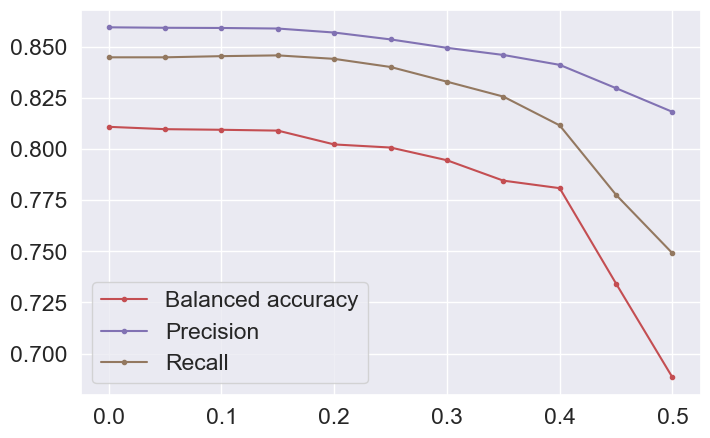

In [70]:
plt.figure(figsize=(8, 5))

plt.plot(pruning['pruning_ratio'], pruning['balanced_acc'], marker='.', ls='-', color="C3", label='Balanced accuracy')
plt.plot(pruning['pruning_ratio'], pruning['precision'], marker='.', ls='-', color="C4", label='Precision')
plt.plot(pruning['pruning_ratio'], pruning['recall'], marker='.', ls='-', color="C5", label='Recall')

plt.legend()
plt.show()

### Analyzing the latent space

In [27]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space(results, n_PCA_components=4):
        
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

    
    pca = PCA(n_components=n_PCA_components)
    pca_train = pca.fit_transform(results['train']['z'], results['train']['labels'])

    fig, axs = plt.subplots(n_PCA_components, n_PCA_components, sharex=True, sharey=True, figsize=(10, 10))
    for row in range(n_PCA_components):
        for col in range(n_PCA_components):
            for i in range(5):
                proj_ = pca_train[results['train']['labels'] == i, :]
                axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
            
            if row == n_PCA_components - 1:
                axs[row, col].set_xlabel(f'PC{col+1}')
            if col == 0:
                axs[row, col].set_ylabel(f'PC{row+1}')

    # plt.legend()
    fig.suptitle(f"TRAIN - PCA")
    plt.show()

    for dtype in ['validation', 'test']:
        pca_proj = pca.transform(results[dtype]['z'])

        fig, axs = plt.subplots(n_PCA_components, n_PCA_components, sharex=True, sharey=True, figsize=(10, 10))
        for row in range(n_PCA_components):
            for col in range(n_PCA_components):
                
                if dtype == 'test':
                    axs[row, col].scatter(pca_proj[:, row], pca_proj[:, col], s=0.5, alpha=0.5, label = 'unknown')

                else:
                    for i in range(5):
                        proj_ = pca_proj[results[dtype]['labels'] == i, :]
                        axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
                
                if row == n_PCA_components - 1:
                    axs[row, col].set_xlabel(f'PC{col+1}')
                if col == 0:
                    axs[row, col].set_ylabel(f'PC{row+1}')

        # plt.legend()
        fig.suptitle(f"{dtype.upper()} - PCA")
        plt.show()
        
    for dtype in ['train', 'validation', 'test']:
        tsne = TSNE(n_components=2)
        projection = tsne.fit_transform(results[dtype]['z'], results[dtype]['labels'])

        plt.figure(figsize=(10, 10))
        if dtype == 'test':
            plt.scatter(projection[:, 0], projection[:, 1], alpha=0.5, label='unknown')
        else:
            for i in range(5):
                proj_ = projection[results[dtype]['labels'] == i, :]
                plt.scatter(proj_[:, 0], proj_[:, 1], alpha=0.5, label = idx2label[i])
        
        plt.title(f'{dtype.upper()} - tSNE projection')
        plt.legend()
        plt.show()

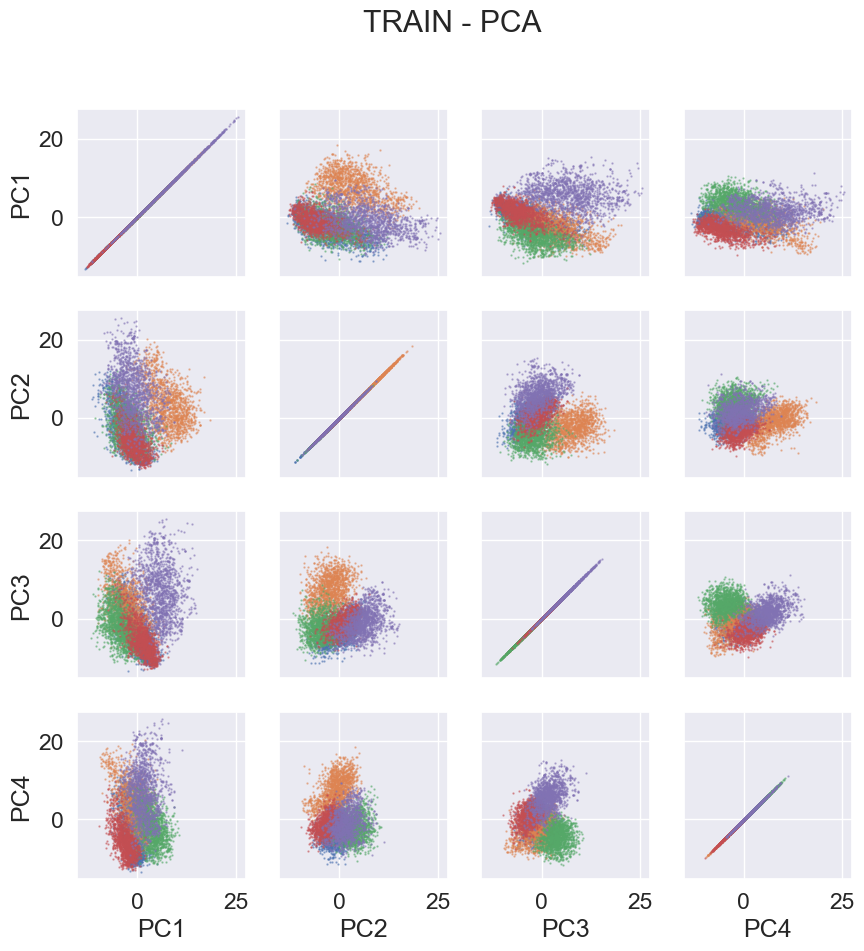

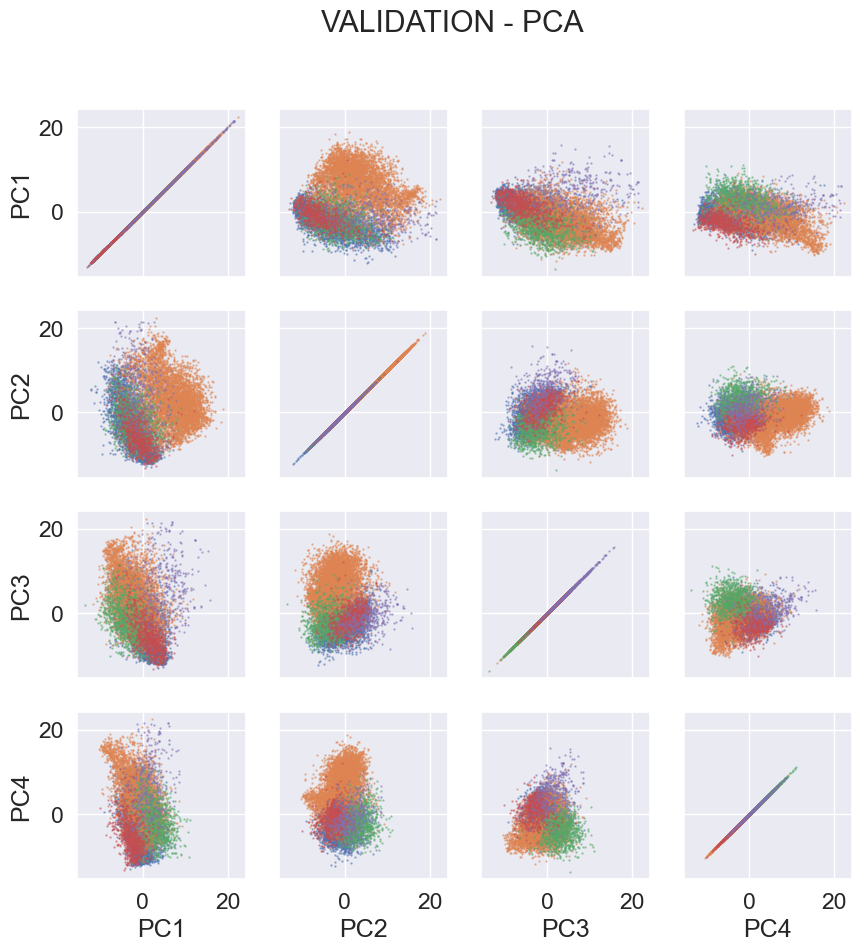

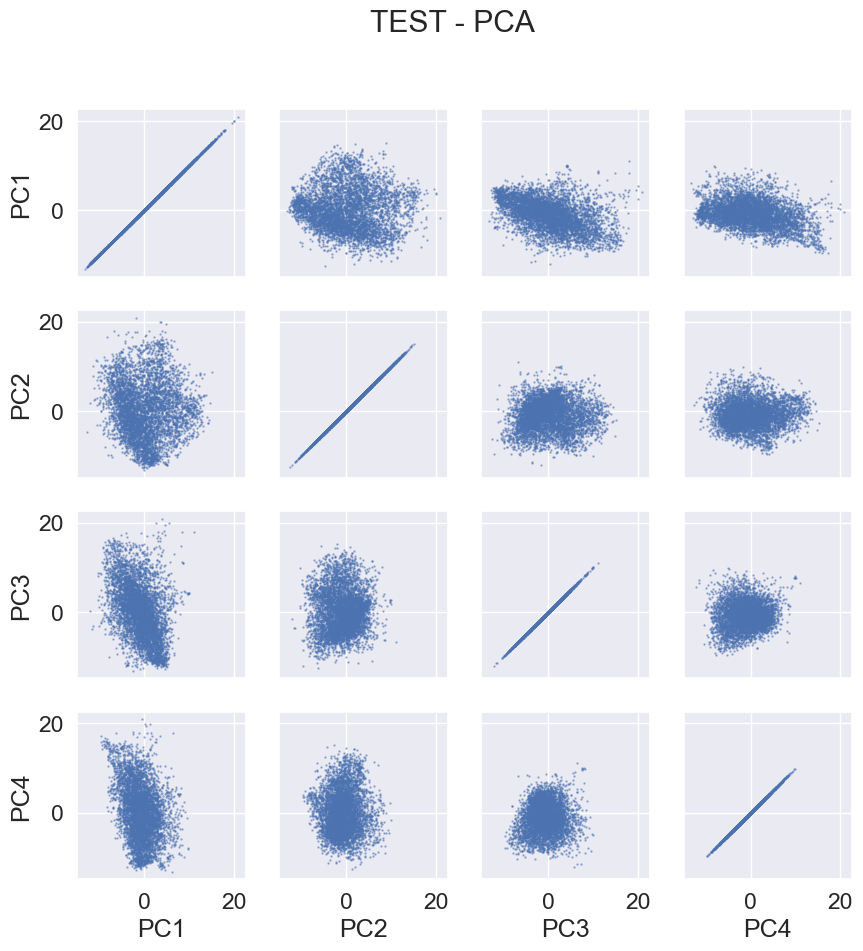

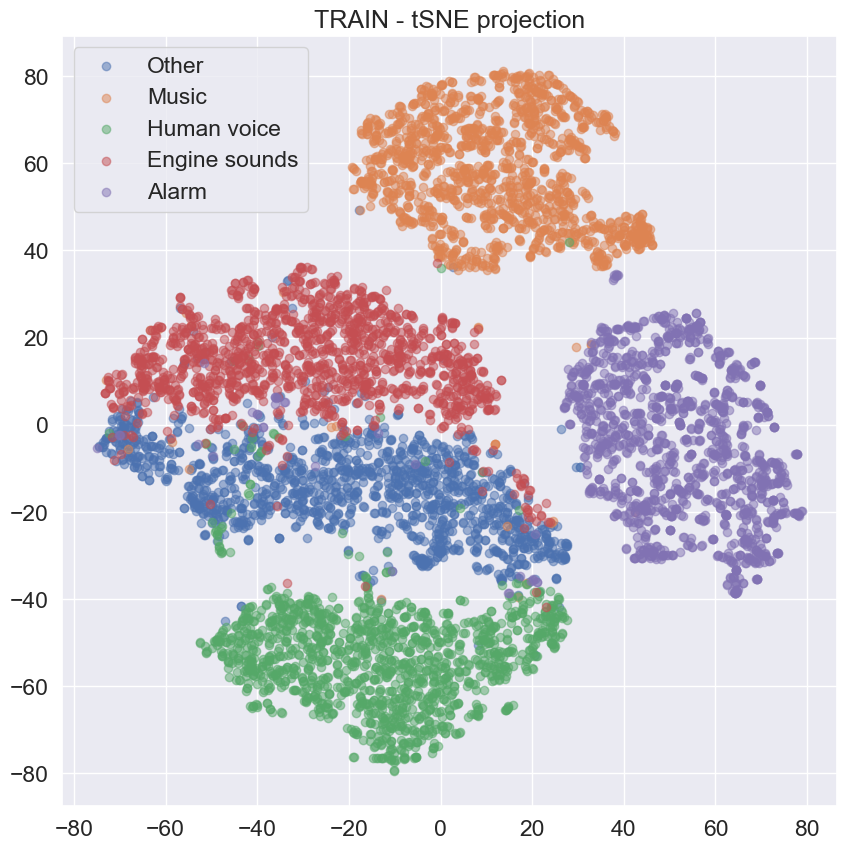

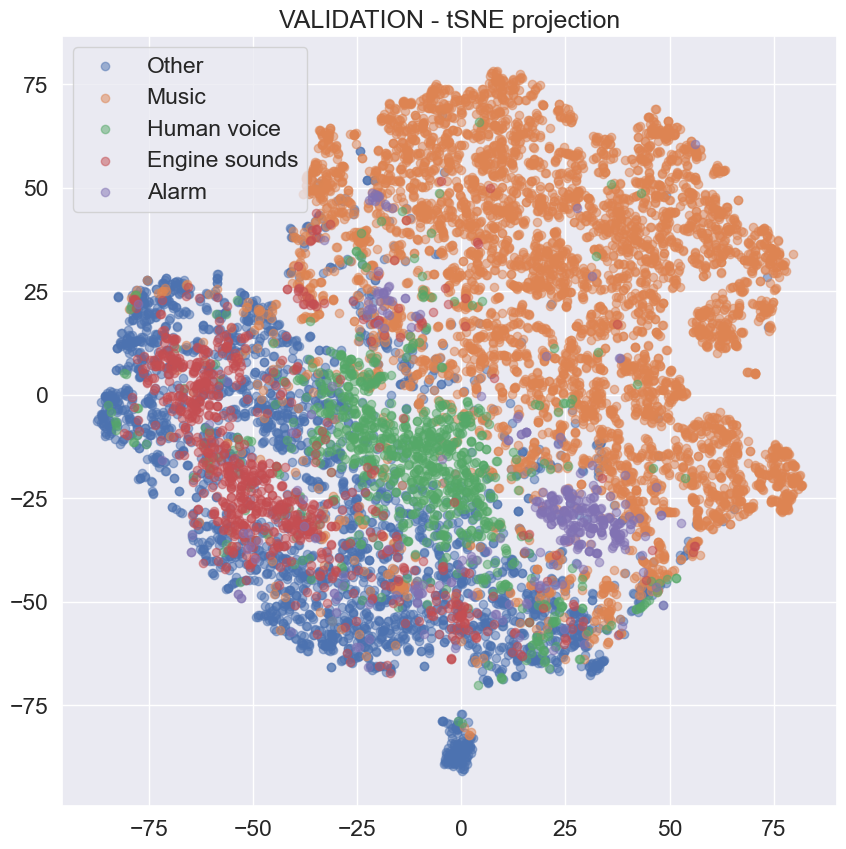

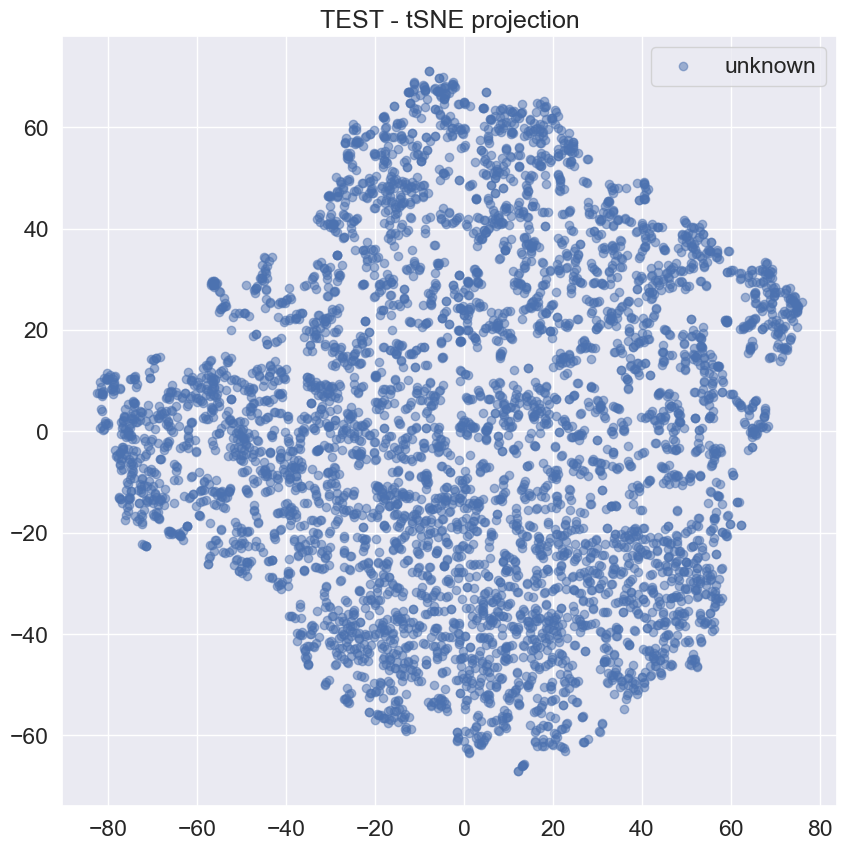

In [28]:
visualize_latent_space(results)

### Visualize stats-ish

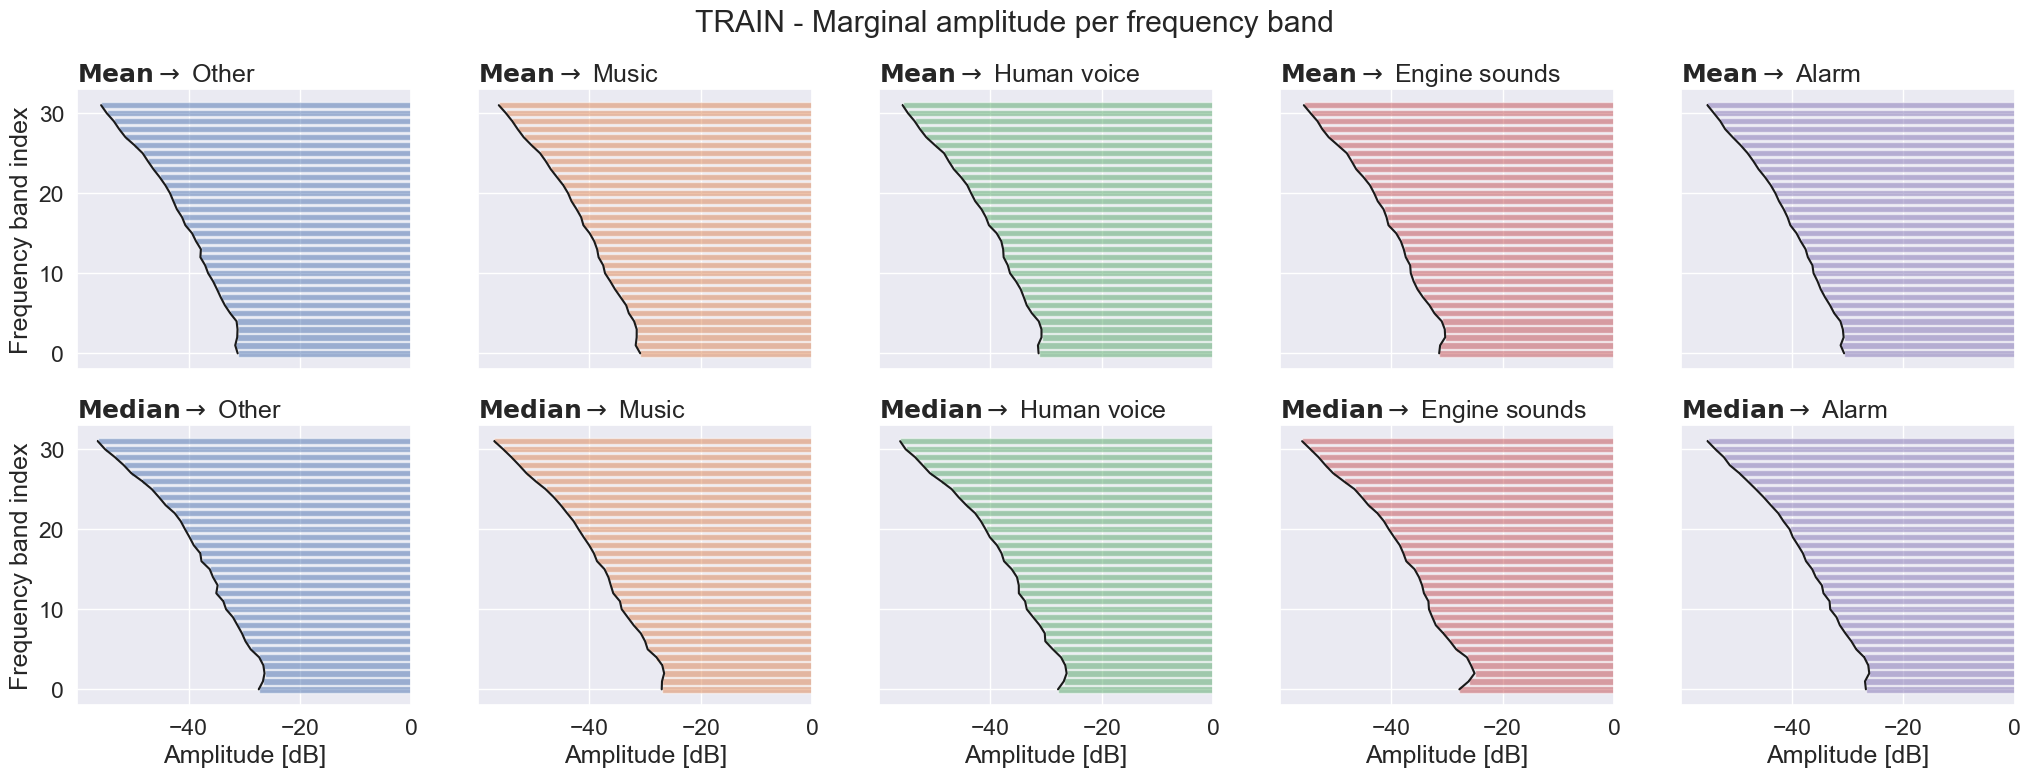

In [29]:
Xtrain = []
for batch in iter(loaders['train']):
    Xtrain.append(batch['data'])
Xtrain = np.vstack(Xtrain)

fig = plot_marginal_frequency(Xtrain.squeeze(1) * sigma + mu, results['train']['labels'], num_classes=5)
fig.suptitle('TRAIN - Marginal amplitude per frequency band')
plt.show()

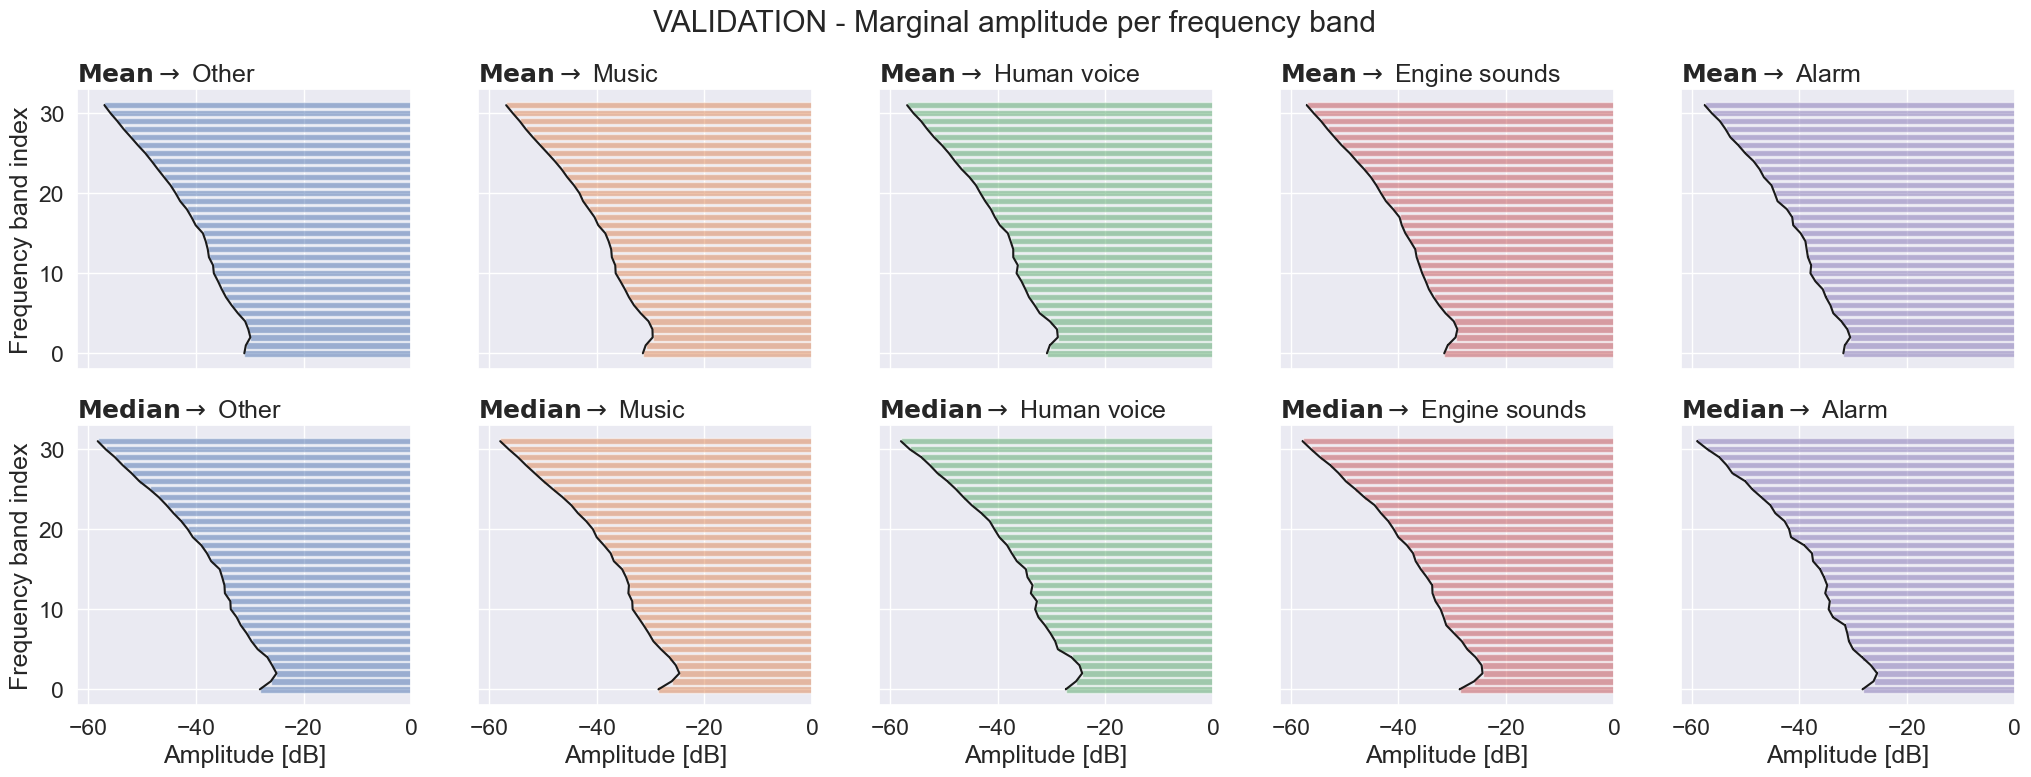

In [30]:
Xval = []
for batch in iter(loaders['val']):
    Xval.append(batch['data'])
Xval = np.vstack(Xval)

fig = plot_marginal_frequency(Xval.squeeze(1) * sigma + mu, results['validation']['labels'], num_classes=5)
fig.suptitle('VALIDATION - Marginal amplitude per frequency band')
plt.show()

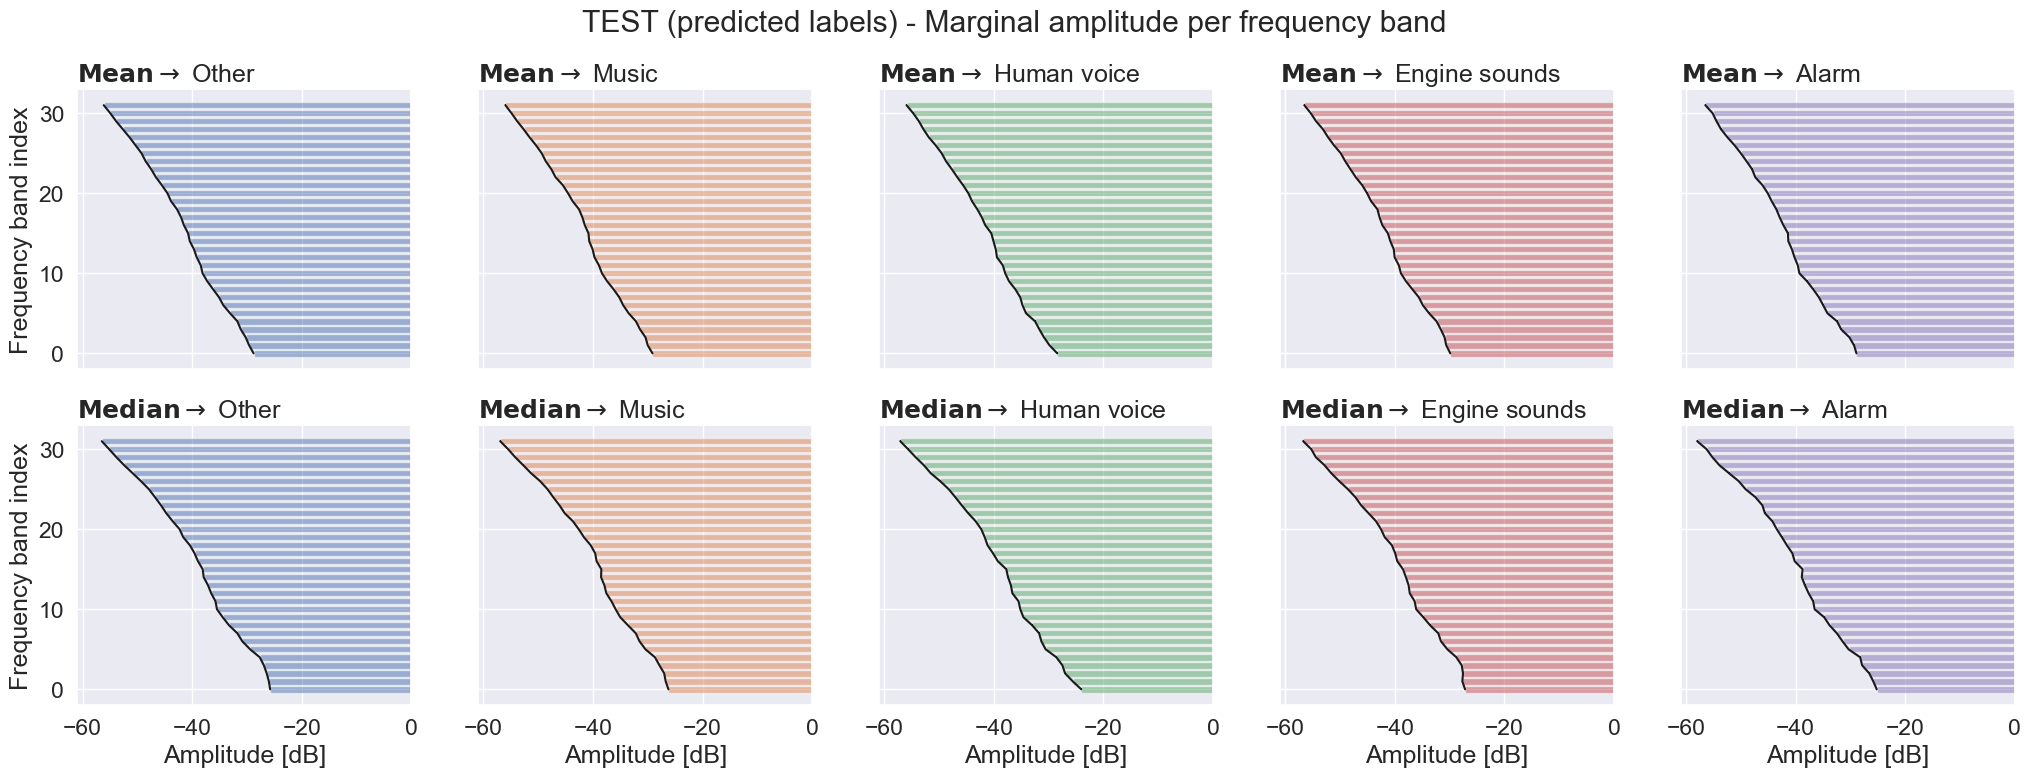

In [31]:
Xtest = []
for batch in iter(loaders['test']):
    Xtest.append(batch['data'])
Xtest = np.vstack(Xtest)

fig = plot_marginal_frequency(Xtest.squeeze(1) * sigma + mu, results['test']['preds'], num_classes=5)
fig.suptitle('TEST (predicted labels) - Marginal amplitude per frequency band')
plt.show()

In [37]:
from collections import Counter

test_dist = Counter(results['test']['preds'])

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

{idx2label[i]: test_dist[i] for i in range(5)}

{'Other': 2195,
 'Music': 1699,
 'Human voice': 503,
 'Engine sounds': 627,
 'Alarm': 323}

In [55]:
def visualize_label_distribution(ttrain, tval, plot = True):
    
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
    label2idx   = {v: k for k, v in idx2label.items()}
    num_classes = len(np.unique(ttrain))
    
    N_train, N_val = len(ttrain), len(tval)
    
    label_dist = {'train': dict(sorted(Counter(ttrain).items(), key=lambda x: -x[1])), 'val': dict(sorted(Counter(tval).items(), key=lambda x: -x[1]))}

    label_counts = {dtype: {idx2label[k]: v for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}
    label_freqs = {dtype: {idx2label[k]: v / (N_train if dtype == 'train' else N_val) for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}

    label_counts['train'] = {idx2label[i]: label_counts['train'][idx2label[i]] for i in range(5)}
    label_counts['val'] = {idx2label[i]: label_counts['val'][idx2label[i]] for i in range(5)}

    if plot:
        # Plot pie chart
        fig = plt.figure(figsize=(10, 5), dpi=200)
        ax1 = plt.subplot2grid((2,2),(0,0))
        plt.pie(x=label_counts['train'].values(), labels=label_counts['train'].keys(), colors=colors)
        plt.title('Test')

        ax1 = plt.subplot2grid((2,2), (0, 1))
        plt.pie(x=label_counts['val'].values(), labels=label_counts['val'].keys(), colors=colors)
        plt.title('Validation')

        plt.tight_layout()
        plt.show()

    return label_counts, label_freqs

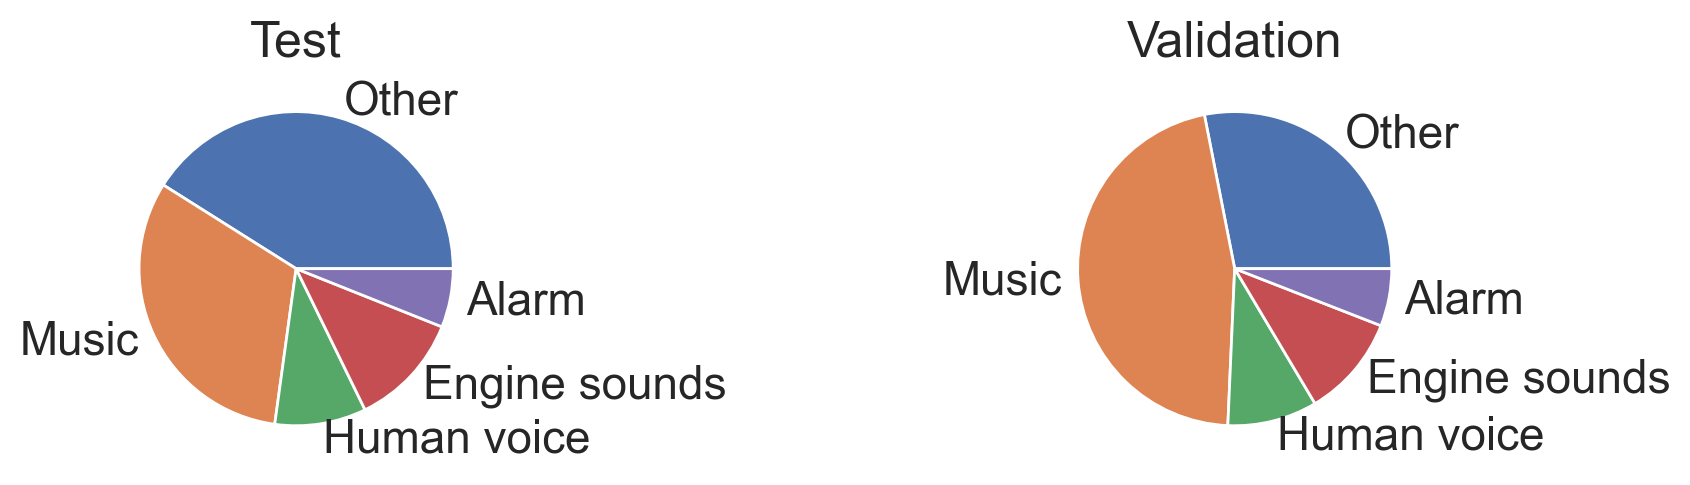

In [57]:
temp, _ = visualize_label_distribution(results['test']['preds'], results['validation']['preds'])

### Evaluate pruning and hardware-related performance

In [4]:
from tqdm.notebook import tqdm

def run_inference_with_computational_metrics(loader, model, device):
    latent_representations, predictions, equals, all_targets, probs = [], [], [], [], []
    memory_usage_data = []

    try:
        os.remove("emissions.csv")
    except:
        None
        
    tracker = EmissionsTracker()
    
    with torch.no_grad():
        for batch in tqdm(iter(loader)):
        
            x       = batch['data'].to(device)
            targets = batch['label'].to(device).to(torch.long)

            tracker.start()
            outputs = model(x)
            memory_usage_data.append(memory_usage()[-1])
            tracker.stop()

            # Store latent representations
            latent_representations.append(outputs['z'].cpu())

            # Store predictions
            preds = outputs['t_logits'].argmax(axis=1)
            predictions.append(preds)
            equals.append(torch.tensor(preds.cpu().numpy() == targets.cpu().numpy()))

            # Store probabilities
            probs.append(outputs['t_logits'].softmax(dim=1)) 

            # Store targets
            all_targets.append(targets)

        computational_metrics = pd.read_csv('emissions.csv')[[
            'timestamp', 'project_name', 'duration', 
            'emissions', 'emissions_rate', 
            'cpu_power', 'gpu_power', 'ram_power', 
            'cpu_energy', 'gpu_energy', 'ram_energy', 'energy_consumed', 
            'os', 'python_version', 
            'cpu_count', 'cpu_model', 'gpu_count', 'gpu_model', 
            'ram_total_size'
        ]]

        # Duration is continuously accumulated
        computational_metrics['duration'] = [computational_metrics['duration'][0]]+[computational_metrics['duration'][i+1] 
                                            - computational_metrics['duration'][i] for i in range(len(computational_metrics['duration']) - 1)]
        computational_metrics['memory_usage'] = memory_usage_data

    # Stack latent representations to one frame
    return (
        torch.vstack(latent_representations).cpu().numpy(), 
        torch.hstack(predictions).cpu().numpy(), 
        torch.vstack(probs).cpu().numpy(), 
        torch.hstack(all_targets).cpu().numpy(), 
        torch.hstack(equals).cpu().numpy(),
        computational_metrics
    )

In [11]:

def prune_eval(pruning_ratios = np.linspace(0.0, 1.0, 21), batch_size = 1)#checkpoint['training_parameters']['batch_size']):

    # for changing batch_size
    # Load data
    loaders, mu, sigma = get_loaders(
        data_path = '../../data',
        balancing_strategy='downsample',
        batch_size = batch_size,
        shuffle=True,
        val_size=0.2,
        seed=checkpoint['seed'],
    )
    
    accuracy = [] 
    balanced_acc = []
    comp_metrics = []

    pruning_ratios = pruning_ratios
    for pruning_ratio in pruning_ratios:

        # Load encoder
        encoder_ = PredictiveEncoder().to(device)
        encoder_.load_state_dict(encoder_state_dict)
        encoder_.eval()

        # Prune
        prune_encoder_(encoder_ = encoder_, pruning_ratio = pruning_ratio)

        # Get predictions
        _, pred_val, _, tval, equals_val, metrics  = run_inference_with_computational_metrics(loaders['val'], encoder_, device=device)

        accuracy.append(equals_val.sum() / equals_val.__len__())
        balanced_acc.append(balanced_accuracy_score(tval, pred_val))
        comp_metrics.append(metrics)


    # Average duration and memory_usage per batch   
    tmp = np.array([table[['duration', 'memory_usage']].mean() for table in comp_metrics])

    # Creating table
    df = pd.DataFrame()
    df['pruning_ratio'] = pruning_ratios
    df['duration'] = tmp[:,0]
    df['memory_usage'] = tmp[:,1]
    df['accuracy'] = accuracy
    df['balanced_acc'] = balanced_acc
    
    return df


In [12]:
df = prune_eval(pruning_ratios = np.linspace(0.0, 1.0, 21), batch_size = 32)

NameError: name 'encoder_state_dict' is not defined

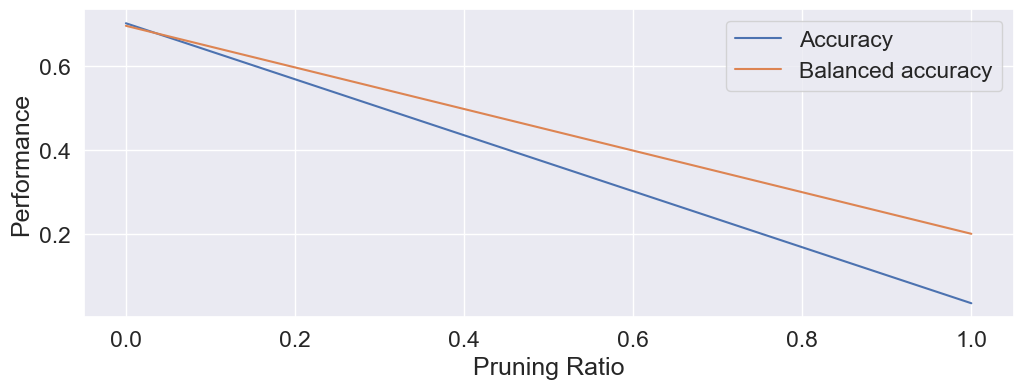

In [106]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['accuracy'], label='Accuracy')
plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Performance')
plt.legend()
plt.show()

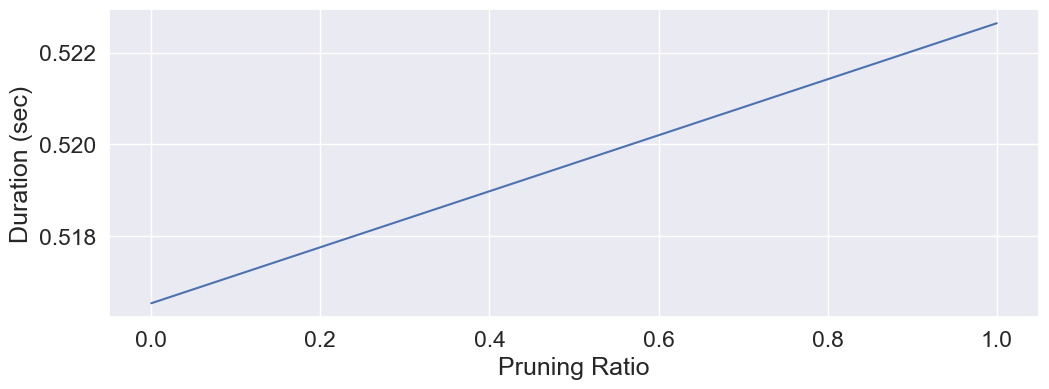

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['duration'], label='Duration (in sec)')
# plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Duration (in sec)')
# plt.legend()
plt.show()

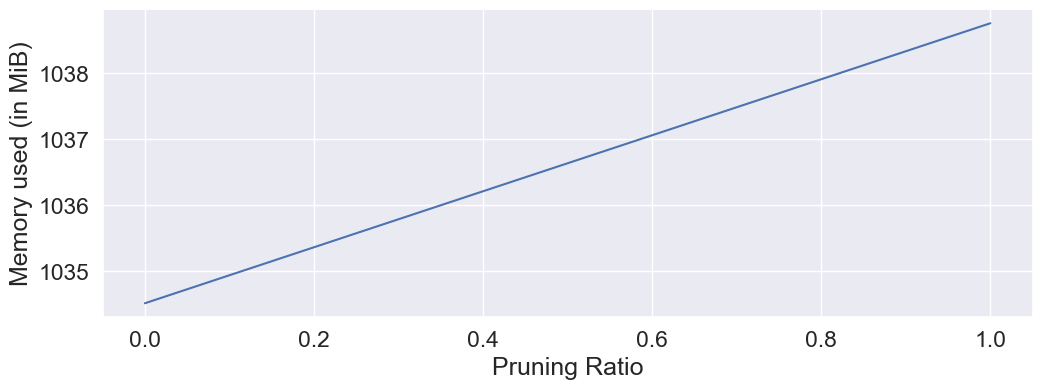

In [111]:
plt.figure(figsize=(12, 4))
plt.plot(pruning_ratios, df['memory_usage'], label = 'Memory used (in MiB)')
# plt.plot(pruning_ratios, df['balanced_acc'], label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Memory used (in MiB)')
#plt.legend()
plt.show()

#### ADDITIONAL: Not used at the moment...

In [ ]:
num_classes     = 5

design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2, x**3, x**4))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# define softmax
softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    # get latent function value
    y = Phi @ theta
    # get soft probabilty scores
    prob = softmax(y)
    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

In [91]:
# Create design matrices
Phi_train       = design_matrix(latent_representations_train)
Phi_val         = design_matrix(latent_representations_val)
Phi_test        = design_matrix(latent_representations_test)

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval)

# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

In [92]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_LS):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.9556
Accuracy validation: 0.7823
Balanced accuracy train: 0.9556
Balanced accuracy validation: 0.7860
